In [51]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, AgglomerativeClustering

In [52]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [53]:
# Read in text file that shows PROSE program to transformation
file_path = 'programs_one_to_one.txt'

with open(file_path, 'r') as file:
    data = file.read()

# Split the data on the word "Program:" but keep it as part of the split results
programs_transformations = data.split("\n")
programs_transformations.remove("")

programs = []
transformations = []
lhs = []
rhs = []

for item in programs_transformations:
    item_split = item.split("==>")
    transformation = item_split[1]
    programs.append(item_split[0])
    transformations.append(transformation)
    transformation_split = transformation.split("->")
    lhs.append(transformation_split[0])
    rhs.append(transformation_split[1])



df = pd.DataFrame({
    'program': programs,
    'transformation': transformations,
    'lhs': lhs,
    'rhs': rhs
})

df

,program,transformation,lhs,rhs
0,"let columnName = ""0"" in let x = ChooseInput(vs...",Computers as Theatre->Computers As Theatre,Computers as Theatre,Computers As Theatre
1,"Concat(let columnName = ""0"" in let x = ChooseI...",Computers As Theatre->Computers as Theatre,Computers As Theatre,Computers as Theatre
2,"Concat(ConstStr(""\""""), Concat(let columnName =...","Brenda Laurel->""Laurel, Brenda""",Brenda Laurel,"""Laurel, Brenda"""
3,"Concat(let columnName = ""0"" in let x = ChooseI...","""Laurel, Brenda""->Brenda Laurel","""Laurel, Brenda""",Brenda Laurel
4,"Concat(let columnName = ""0"" in let x = ChooseI...",Tru64 Unix Troubleshooting Diagnosing &amp;->T...,Tru64 Unix Troubleshooting Diagnosing &amp;,Tru64 UNIX Troubleshooting : Diagnosing and Co...
...,...,...,...,...
485,"Concat(ConstStr(""\""""), Concat(let columnName =...","""Farin, Gerald""->""Gerald E. Farin,""","""Farin, Gerald""","""Gerald E. Farin,"""
486,"Concat(let columnName = ""0"" in let x = ChooseI...",Computer Systems Design and Architecture->Comp...,Computer Systems Design and Architecture,Computer Systems Design and Architecture (2nd ...
487,"let columnName = ""0"" in let x = ChooseInput(vs...",Computer Systems Design and Architecture (2nd ...,Computer Systems Design and Architecture (2nd ...,Computer Systems Design and Architecture
488,"Concat(ConstStr(""\""Vincent P. ""), Concat(let c...","Heuring->""Vincent P. Heuring, Harry F. Jordan""",Heuring,"""Vincent P. Heuring, Harry F. Jordan"""


In [56]:
file_path = 'transformation_feature.tsv'

df.to_csv(file_path, sep='\t', index=False)

In [ ]:
source = df.iloc[:, 4]

transformation_embeddings = [model.encode(text) for text in source]

In [ ]:
np.save('author_embeddings.npy', transformation_embeddings)

In [ ]:
cosine_similarities = cosine_similarity(transformation_embeddings)
print(cosine_similarities.shape)

(492, 492)


In [ ]:
# Brute force approach: Group together all indices where cosine similarity is > 0.8
# undirected_graph = {} 
# for i in range(len(cosine_similarities)):
#     undirected_graph[i] = []

# for i in range(len(cosine_similarities)):
#     for j in range(i+1, len(cosine_similarities[0])):
#         if cosine_similarities[i][j] > 0.8:
#             undirected_graph[i].append(j)
#             undirected_graph[j].append(i)

row_indices, col_indices = np.where(cosine_similarities > 0.8)

groups = {}
undirected_graph = {} 


# Iterate over unique row indices
for i in np.unique(row_indices):
    # Find the column indices where cosine_similarities > 0.8 for this row
    relevant_cols = col_indices[row_indices == i]

    if i not in undirected_graph:
        undirected_graph[i] = []
    undirected_graph[i].extend(relevant_cols.tolist())

    for col in relevant_cols:
        if col not in undirected_graph:
            undirected_graph[col] = []
        undirected_graph[col].append(i)
    
    # Store relevant column indices in groups
    groups[i] = relevant_cols.tolist()

# Convert the lists to sets to remove duplicates in the undirected graph
for key in undirected_graph:
    undirected_graph[key] = list(set(undirected_graph[key]))

for i in range(len(df)):
    if i not in groups:
        groups[i] = []
    if i not in undirected_graph:
        undirected_graph[i] = [i]

In [ ]:
graph = groups.copy()
clusters = []
visited = set()

def dfs(v, curr_cluster):
    visited.add(v)
    curr_cluster.append(v)
    for w in graph[v]:
        if w not in visited:
            dfs(w, curr_cluster)

for node in graph:
    if node not in visited:
        cluster = []
        dfs(node, cluster)
        clusters.append(cluster)

# print(clusters)

In [ ]:
with open('clusters.txt', 'w') as f:
    for clus in clusters:
        f.write('[')
        for idx in clus:
            f.write(f'{authors.iloc[idx]}; ')
        f.write(']\n\n')

In [ ]:
print(len(clusters))
unique_values_count = df.iloc[:, 0].nunique()
print("Number of unique values in 'isbn' column:", unique_values_count)

1877
Number of unique values in 'isbn' column: 876


In [ ]:
#### Testing phase ####
# For now, set the golden entity to be the string with the longest length in the cluster
df_cleaned = df.copy(deep=True)

longest_authors = []

for cluster in clusters:
    cluster_strings = authors.iloc[cluster]
    longest_author = max(cluster_strings, key=len)
    longest_authors.append(longest_author)
    # print(f'{cluster_strings}\nLongest author: {longest_author}\n#######################\n')
    for clust_idx in cluster:
        df_cleaned.iloc[clust_idx, 3] = longest_author

# Output DataFrame to a TSV file
output_file = 'cleaned-book.tsv'
df_cleaned.to_csv(output_file, sep='\t', index=False)

In [ ]:
#### For each ISBN, count the number of unique authors ####
result = df_cleaned.groupby(1)[3].nunique()
print(result)
result.to_csv('result.tsv', sep='\t', index=True)


1
0023606924       4
0080439977       5
0120121484       3
0120121506       3
0120121514       3
                ..
9780078204616    2
9780078216770    2
9780078227813    2
9780079136787    5
9780335216369    2
Name: 3, Length: 1263, dtype: int64


In [ ]:
########## Find precision and recall: start by identifying true positives and negatives ##########
np.random.seed(4)
same_second_col = []
diff_second_col = []

# Create a dictionary where keys are the unique values in the second column,
# and values are the corresponding rows
groups = {k: v for k, v in df.groupby(df.iloc[:, 1])}

for key, group in groups.items():
    # Get all possible pairs within each group
    pairs = list(zip(group.index, [key]*len(group), group.iloc[:, 3], group.index[1:], group.iloc[:, 3][1:]))
    same_second_col.extend(pairs)

# Shuffle the pairs to ensure randomness
np.random.shuffle(same_second_col)

# Get only the first 500 pairs
same_second_col = same_second_col[:500]

# For getting pairs with different second column values
while len(diff_second_col) < 500:
    # Randomly select two groups
    group1, group2 = np.random.choice(list(groups.keys()), 2, replace=False)
    if len(groups[group1]) > 0 and len(groups[group2]) > 0:
        # Randomly select one row from each group
        row1 = groups[group1].iloc[:, 3].sample(1)
        row2 = groups[group2].iloc[:, 3].sample(1)
        diff_second_col.append((row1.index[0], group1, row1.values[0], row2.index[0], group2, row2.values[0]))

print("Pairs with same second column value: ", same_second_col)
print("Pairs with different second column value: ", diff_second_col)

Pairs with same second column value:  [(31424, '0130853755', 'Johnston', 31425, 'Johnston, Barbara'), (13592, '0201787334', 'Pohl, Ira', 13593, 'Pohl'), (4157, '0201770040', 'Maruyama, Hiroshi Tamura, Kent Uramoto, Naohiko Murata, Makoto Clark, Andy Nakamura, Yuichi', 4158, 'Maruyama, Hiroshi; Nakamura, Yuichi'), (30719, '0124383807', 'Laurini, Robert; Thompson, Derek', 30720, 'Robert Laurini; Derek Thompson'), (16249, '0201794276', 'Raggett, Isobel; Aufgang, Joel', 16250, 'Doug Wallace, Isobel Raggett, Joel Aufgang'), (29711, '0121942759', 'Cox, Earl', 29712, 'Earl Cox'), (6050, '0321423437', 'Gagne- Marcel', 6051, 'Gagn&eacute;, Marcel'), (31525, '0131426419', 'Deitel, Harvey M.; Deitel, Paul J.; Hoey, Tim; Yaeger, Cheryl H.', 31526, 'P. J. Deitel'), (12956, '0201310058', 'Bloch, Joshua', 12957, 'Bloch, Josh, and Steele, Guy L, Jr. (Foreword by)'), (32427, '0132438623', 'Deitel, P. J./ Deitel, H. M.', 32428, 'Associates, Staff of Deitel &amp;'), (23574, '1558608877', '0', 23575, 'Jam

In [ ]:
############# Find True/False Positives, True/False negatives #############

# graph = groups.copy()
# clusters = []
# visited = set()

# see if there's a path from start to target
def can_reach(start, target, visited, graph):
    if visited is None:
        visited = set()
    visited.add(start)
    if start == target:
        return True
    for w in graph[start]:
        if w not in visited:
            if can_reach(w, target, visited, graph):
                return True
    return False

tp = fp = tn = fn = 0
for row_idx1, isbn, author1, row_idx2, author2 in same_second_col:
    if can_reach(row_idx1, row_idx2, set(), undirected_graph):
        tp += 1
    else:
        fn +=1 

for row_idx1, isbn1, author1, row_idx2, isbn2, author2 in diff_second_col:
    if can_reach(row_idx1, row_idx2, set(), undirected_graph):
        fp += 1
    else:
        tn +=1

precision = tp/(tp + fp)
recall = tp/(tp + fn)
mcc = (tp*tn - fp*fn) / (np.sqrt(
    (tp + fp)*(tp+fn)*(tn+fp)*(tn+fn)
))

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'MCC: {mcc}')

Precision: 1.0
Recall: 0.792
MCC: 0.8097092929396622


10


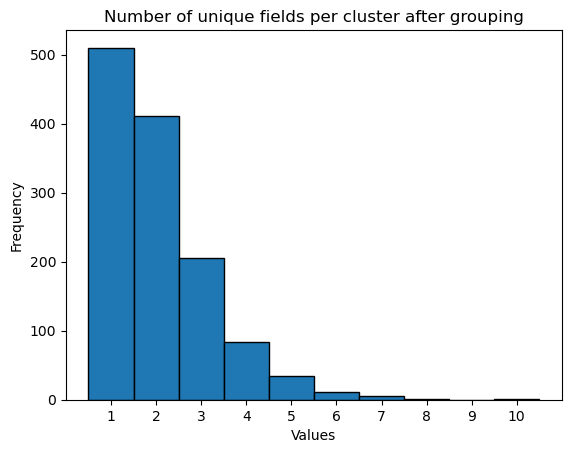

mean:  2.0427553444180524
median:  2.0
std:  1.1895248060401993
1st quartile:  1.0
3rd quartile:  3.0


In [ ]:
import matplotlib.pyplot as plt
# print(result.iloc[1])
print(result.max())
n_bins = result.max()
n, bins, patches = plt.hist(result, bins=n_bins, edgecolor='black') 
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Number of unique fields per cluster after grouping')
# Calculate centers of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Set x-axis ticks to the calculated bin centers
plt.xticks(bin_centers, range(1, n_bins+1))
plt.show()

print('mean: ', result.mean())
print('median: ', result.median())
print('std: ', result.std())
print('1st quartile: ', result.quantile(0.25))
print('3rd quartile: ', result.quantile(0.75))

29


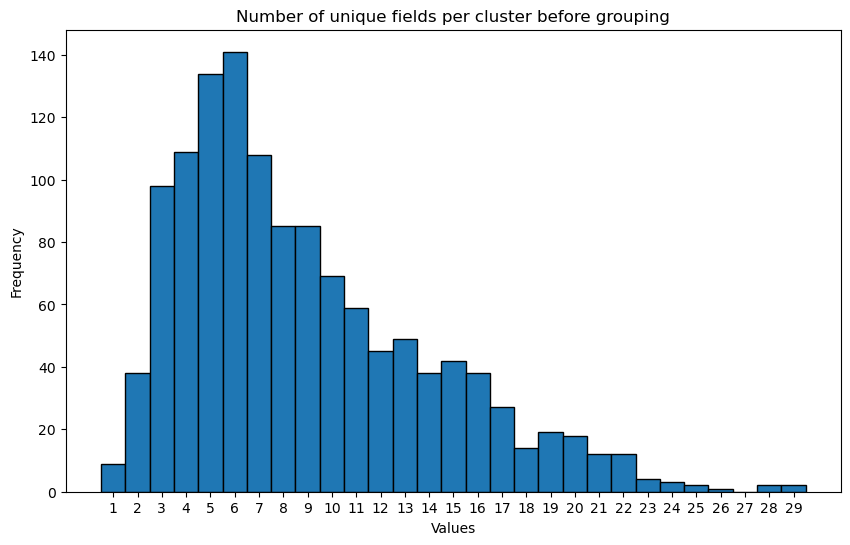

mean:  8.80443388756928
median:  7.0
std:  5.103422857019719
1st quartile:  5.0
3rd quartile:  12.0


In [ ]:
old_df = df.groupby(1)[3].nunique()

print(old_df.max())
n_bins = old_df.max()
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(old_df, bins=n_bins,edgecolor='black') 
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Number of unique fields per cluster before grouping')
# Calculate centers of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Set x-axis ticks to the calculated bin centers
plt.xticks(bin_centers, range(1, n_bins+1))
plt.show()

print('mean: ', old_df.mean())
print('median: ', old_df.median())
print('std: ', old_df.std())
print('1st quartile: ', old_df.quantile(0.25))
print('3rd quartile: ', old_df.quantile(0.75))

Authors filtered length: 30115
1
0023606924       3
0080439977       2
0120121484       2
0120121506       3
0120121514       2
                ..
9780078204616    2
9780078216770    1
9780078227813    2
9780079136787    2
9780335216369    2
Name: 3, Length: 1261, dtype: int64
6


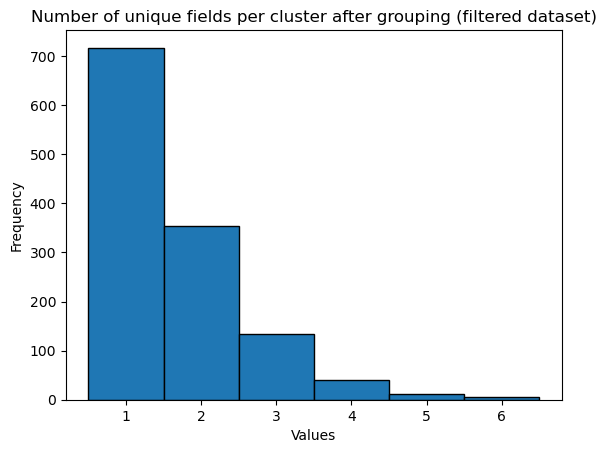

1.6447264076130055
1.0
0.9062557851421786
1.0
2.0


In [ ]:
### Exploration: How well does this work in cases where there are
### no fields where the author is just one name, or several authors
### are abbreviated to et al?
import re

def remove_substrings(cell):
    if isinstance(cell, str):
        return re.sub(r'\b(author|by|edited|editor)\b', '', cell, flags=re.IGNORECASE)
    else:
        return cell

#### Drop the relevant rows and recreate embeddings + cosine similarity matrix
df = df.reset_index(drop=True)
df_filtered = df[~((df.iloc[:, 3].str.split().str.len() == 1) | (df.iloc[:, 3].str.contains('et al|et. al')))]
df_filtered.iloc[:,3] = df_filtered.iloc[:,3].apply(remove_substrings)
authors = df_filtered.iloc[:, 3]

print(f'Authors filtered length: {len(authors)}')

# author_embeddings_filtered = [model.encode(author) for author in authors]
author_embeddings_filtered = np.load('author_embeddings_filtered.npy')
np.save('author_embeddings_filtered.npy', author_embeddings_filtered)

cosine_similarities_filtered = cosine_similarity(author_embeddings_filtered)

#### Cluster the similar authors
row_indices_f, col_indices_f = np.where(cosine_similarities_filtered > 0.8)
groups_f = {}
# Iterate over unique row indices
for i in np.unique(row_indices_f):
    # Find the column indices where cosine_similarities > 0.8 for this row
    relevant_cols_f = col_indices_f[row_indices_f == i]
    
    # Store relevant column indices in groups
    groups_f[i] = relevant_cols_f.tolist()

graph_f = groups_f.copy()
clusters_f = []
visited_f = set()

def dfs_f(v, curr_cluster):
    visited_f.add(v)
    curr_cluster.append(v)
    for w in graph_f[v]:
        if w not in visited_f:
            dfs_f(w, curr_cluster)

for node_f in graph_f:
    if node_f not in visited_f:
        cluster_f = []
        dfs_f(node_f, cluster_f)
        clusters_f.append(cluster_f)


#### Testing phase ####
df_cleaned_f = df_filtered.copy(deep=True)

longest_authors_f = []

for cluster_f in clusters_f:
    cluster_strings_f = authors.iloc[cluster_f]
    longest_author_f = max(cluster_strings_f, key=len)
    longest_authors_f.append(longest_author_f)
    # print(f'{cluster_strings}\nLongest author: {longest_author}\n#######################\n')
    for clust_idx in cluster_f:
        df_cleaned_f.iloc[clust_idx, 3] = longest_author_f

# Output DataFrame to a TSV file
output_file_f = 'cleaned-book-filtered.tsv'
df_cleaned_f.to_csv(output_file_f, sep='\t', index=False)

#### For each ISBN, count the number of unique authors ####
result_f = df_cleaned_f.groupby(1)[3].nunique()
print(result_f)
result_f.to_csv('result-filtered.tsv', sep='\t', index=True)

print(result_f.max())
n_bins = result_f.max()
n, bins, patches = plt.hist(result_f, bins=n_bins, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Number of unique fields per cluster after grouping (filtered dataset)')
# Calculate centers of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Set x-axis ticks to the calculated bin centers
plt.xticks(bin_centers, range(1, n_bins+1))
plt.show()

print(result_f.mean())
print(result_f.median())
print(result_f.std())
print(result_f.quantile(0.25))
print(result_f.quantile(0.75))

In [ ]:
#######################################################################################
#################### Now let's do all this on the titles column!!! ####################
#######################################################################################
df = pd.read_csv('book.tsv', sep='\t', header=None) # reread the data in case we messed with it
df = df.dropna(subset=[df.columns[2]])
titles = df.iloc[:, 2]

# title_embeddings = [model.encode(title) for title in titles]
title_embeddings = np.load('title_embeddings.npy')
# np.save('title_embeddings.npy', title_embeddings)

In [ ]:
cosine_similarities_titles = cosine_similarity(title_embeddings)

# Construct the graph
row_indices, col_indices = np.where(cosine_similarities_titles > 0.8)
groups = {}
# Iterate over unique row indices
for i in np.unique(row_indices):
    # Find the column indices where cosine_similarities > 0.8 for this row
    relevant_cols = col_indices[row_indices == i]
    
    # Store relevant column indices in groups
    groups[i] = relevant_cols.tolist()

# Find the clusers 
graph = groups.copy()
clusters = []
visited = set()

def dfs(v, curr_cluster):
    visited.add(v)
    curr_cluster.append(v)
    for w in graph[v]:
        if w not in visited:
            dfs(w, curr_cluster)

for node in graph:
    if node not in visited:
        cluster = []
        dfs(node, cluster)
        clusters.append(cluster)

with open('clusters-titles.txt', 'w') as f:
    for clus in clusters:
        f.write('[')
        for idx in clus:
            f.write(f'{titles.iloc[idx]}; ')
        f.write(']\n\n')

print('Number of clusters: ', len(clusters))
unique_values_count = df.iloc[:, 0].nunique()
print("Number of unique values in 'isbn' column:", unique_values_count)



Number of clusters:  1580
Number of unique values in 'isbn' column: 894


1
0023606924       2
0080439977       3
0120121484       3
0120121506       4
0120121514       2
                ..
9780078204616    3
9780078216770    2
9780078227813    3
9780079136787    3
9780335216369    1
Name: 2, Length: 1265, dtype: int64
6


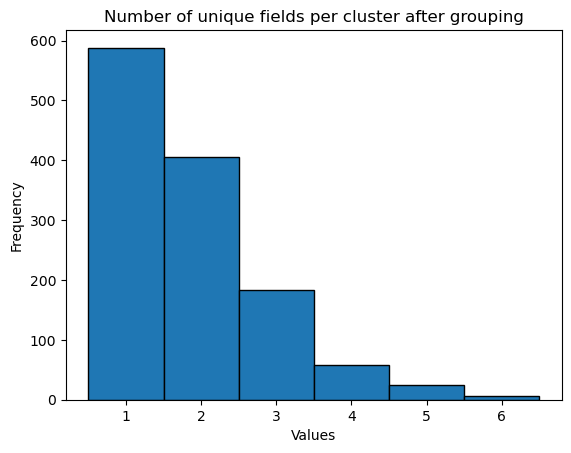

mean:  1.8474308300395257
median:  2.0
std:  1.0084901258897467
1st quartile:  1.0
3rd quartile:  2.0


In [ ]:
#### Testing phase ####
# For now, set the golden entity to be the string with the longest length in the cluster
df_cleaned = df.copy(deep=True)

longest_titles = []

for cluster in clusters:
    cluster_strings = titles.iloc[cluster]
    longest_title = max(cluster_strings, key=len)
    longest_titles.append(longest_title)
    for clust_idx in cluster:
        df_cleaned.iloc[clust_idx, 2] = longest_title

# Output DataFrame to a TSV file
output_file = 'cleaned-book-titles.tsv'
df_cleaned.to_csv(output_file, sep='\t', index=False)

#### For each ISBN, count the number of unique titles ####
result = df_cleaned.groupby(1)[2].nunique()
print(result)
result.to_csv('result-titles.tsv', sep='\t', index=True)

# print(result.iloc[1])
print(result.max())
n_bins = result.max()
n, bins, patches = plt.hist(result, bins=n_bins, edgecolor='black') 
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Number of unique fields per cluster after grouping')
# Calculate centers of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Set x-axis ticks to the calculated bin centers
plt.xticks(bin_centers, range(1, n_bins+1))
plt.show()

print('mean: ', result.mean())
print('median: ', result.median())
print('std: ', result.std())
print('1st quartile: ', result.quantile(0.25))
print('3rd quartile: ', result.quantile(0.75))

In [ ]:
########## Find precision and recall ##########
